# Load librarys

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os, shutil
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

# Load the images and create neural network model with TensorFlow 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import matplotlib.pyplot as plt

### Get Data and associate Labes


In [4]:
# Dataset
import zipfile

# Extract the dataset
z = zipfile.ZipFile('archive.zip')

# Extract all the contents of zip file in current directory to a new folder named 'data'
z.extractall('data')


Number of images in tumor folder: 1683
Number of images in non_tumor folder: 2079


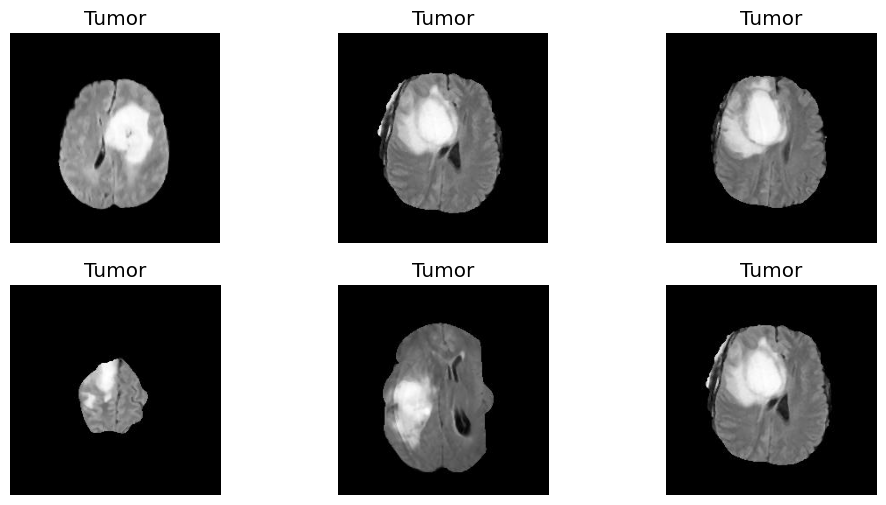

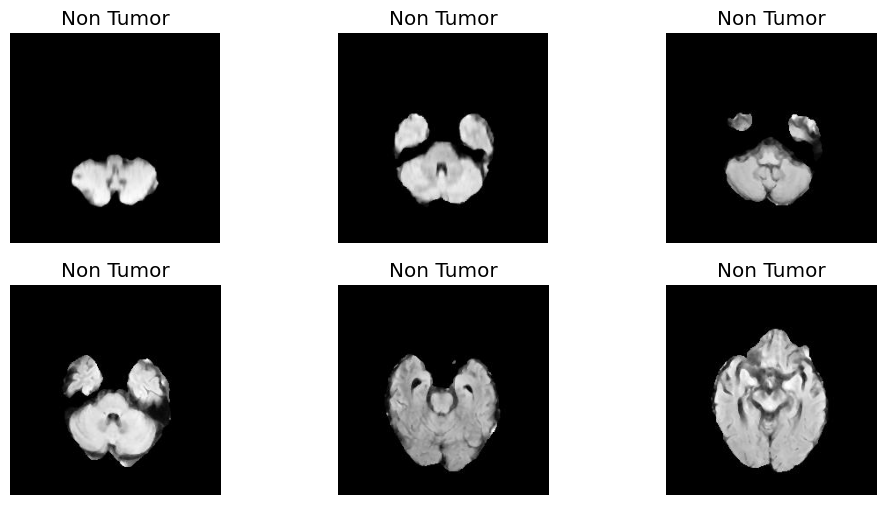

In [5]:
label_csv = pd.read_csv('data/Brain Tumor.csv')
label_csv.head()

image_folder = 'data/Brain Tumor/Brain Tumor'

# Save all the images to a folder named tumor and non_tumor
tumor_folder = 'data/labeled/tumor'
non_tumor_folder = 'data/labeled/non_tumor'

# Create the folders
os.makedirs(tumor_folder, exist_ok=True)
os.makedirs(non_tumor_folder, exist_ok=True)

# Copy the images to the folders
for index, row in label_csv.iterrows():
    image_path = os.path.join(image_folder, row['Image']+ '.jpg')
    if row['Class'] == 1:
        shutil.copy(image_path, tumor_folder)
    else:
        shutil.copy(image_path, non_tumor_folder)

# Check the number of images in each folder
print('Number of images in tumor folder:', len(os.listdir(tumor_folder)))
print('Number of images in non_tumor folder:', len(os.listdir(non_tumor_folder)))

# Display a few images from each folder
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(tumor_folder, os.listdir(tumor_folder)[i])))
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mpimg.imread(os.path.join(non_tumor_folder, os.listdir(non_tumor_folder)[i])))
    plt.title('Non Tumor')
    plt.axis('off')
plt.show()


#### Load Data with tensorflow as pipline

Found 3762 files belonging to 2 classes.


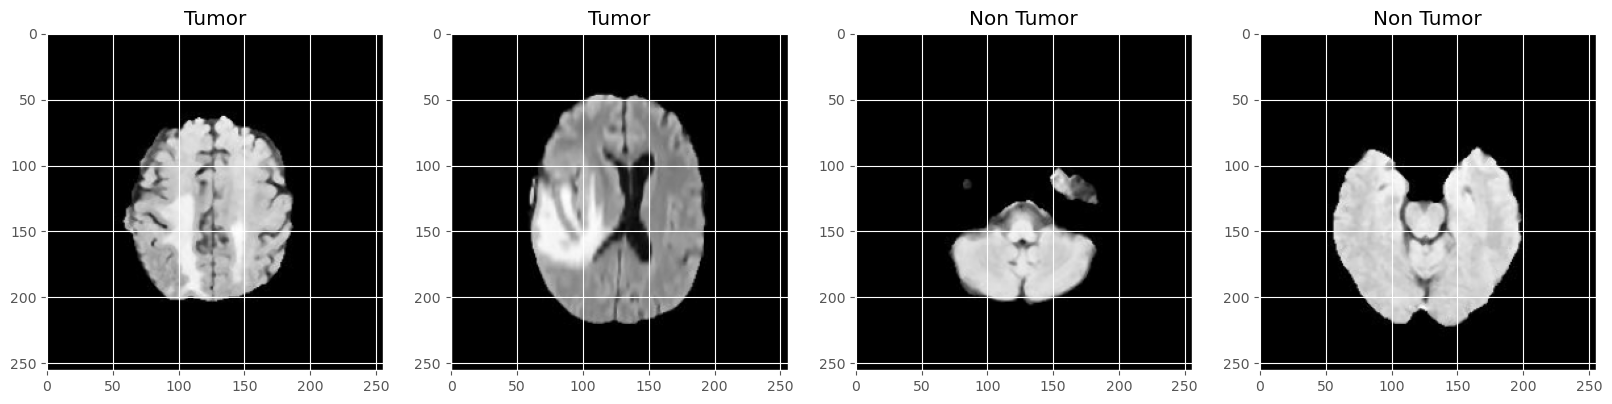

In [4]:
# building data pipeline
data = tf.keras.utils.image_dataset_from_directory('data/labeled')


# create a data iterator
data_iterator = data.as_numpy_iterator()

# creat a batch 
batch = data_iterator.next()

# images represented as numpy arrays
batch[0].shape

# plot the batch to see which class belongs to which image
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # set the title of the image with tumor or non_tumor
    ax[idx].title.set_text('Tumor' if batch[1][idx] == 1 else 'Non Tumor')


# Preprocessing

In [3]:
# pincip of scaling
# Just for testing don't run this code
"""
scaled = batch[0] / 255
scaled.max()
"""

# TODO: DELETE?

'\nscaled = batch[0] / 255\nscaled.max()\n'

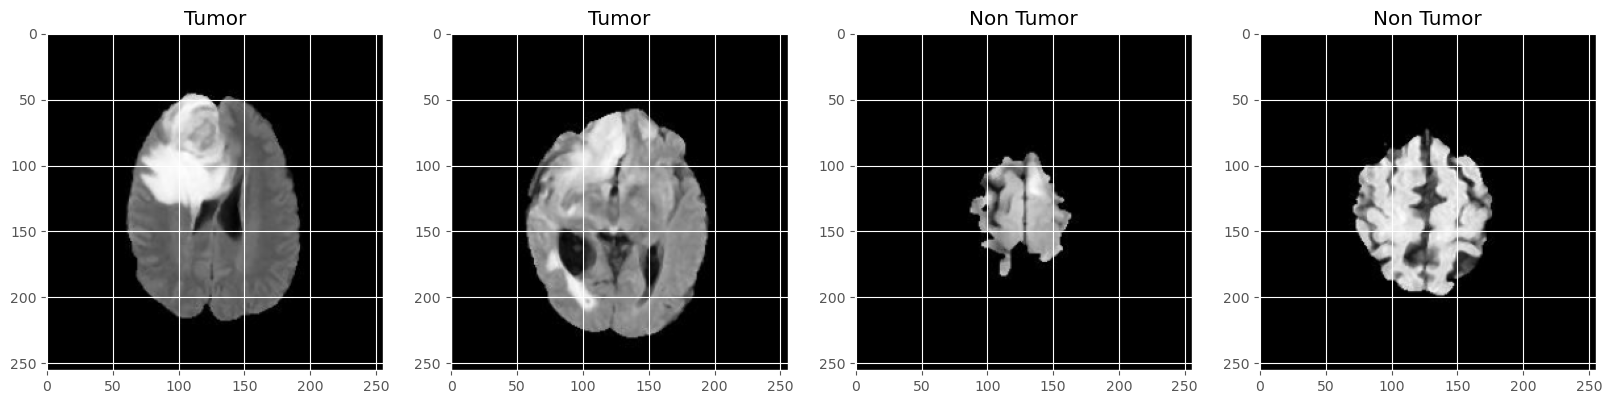

In [5]:
# scale the data pipline on the fly 
data = data.map(lambda x, y: (x/255, y))

scaled_interator = data.as_numpy_iterator()
scaled_batch = scaled_interator.next()
scaled_batch[0].min()

# display the batch
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(scaled_batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text('Tumor' if batch[1][idx] == 1 else 'Non Tumor')

Split Data

In [6]:
# decide the size of the train, validation and test datasets
print(len(data))
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

train_size + val_size + test_size

118


118

In [7]:
# split the data into train, validation and test
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

print(len(train), len(val), len(test))


82 24 12


# Data Augementation

In [8]:
# Define data augmentation only for training
train_data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=(-0.3, 0.3), width_factor=(-0.3, 0.3))
])

# Apply augmentation to the training dataset
train = train.map(lambda x, y: (train_data_augmentation(x, training=True), y))


# Modeling 

In [9]:
batch[0].shape

(32, 256, 256, 3)

## Model 1: New Model

c:\Users\fr3m3\anaconda3\envs\NeuNe_tensor\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    33,554,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,579,041 (128.09 MB)

 Trainable params: 33,579,041 (128.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 57s 672ms/step - binary_accuracy: 0.6060 - loss: 0.7296 - precision_2: 0.5610 - recall_2: 0.6222 - val_binary_accuracy: 0.8008 - val_loss: 0.4929 - val_precision_2: 0.8943 - val_recall_2: 0.6114
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 658ms/step - binary_accuracy: 0.7891 - loss: 0.4624 - precision_2: 0.7588 - recall_2: 0.7710 - val_binary_accuracy: 0.8555 - val_loss: 0.3387 - val_precision_2: 0.8450 - val_recall_2: 0.8329
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 657ms/step - binary_accuracy: 0.8067 - loss: 0.3995 - precision_2: 0.7862 - recall_2: 0.7909 - val_binary_accuracy: 0.8724 - val_loss: 0.3157 - val_precision_2: 0.8922 - val_recall_2: 0.8077
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 665ms/step - binary_accuracy: 0.8221 - loss: 0.4177 - precision_2: 0.8054 - recall_2: 0.7986 - val_binary_accuracy: 0.8659 - val_loss: 0.3376 - val_precision_2: 0.9010 - val_recall_2: 0.7890
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 55s 669ms/step - binary_accura

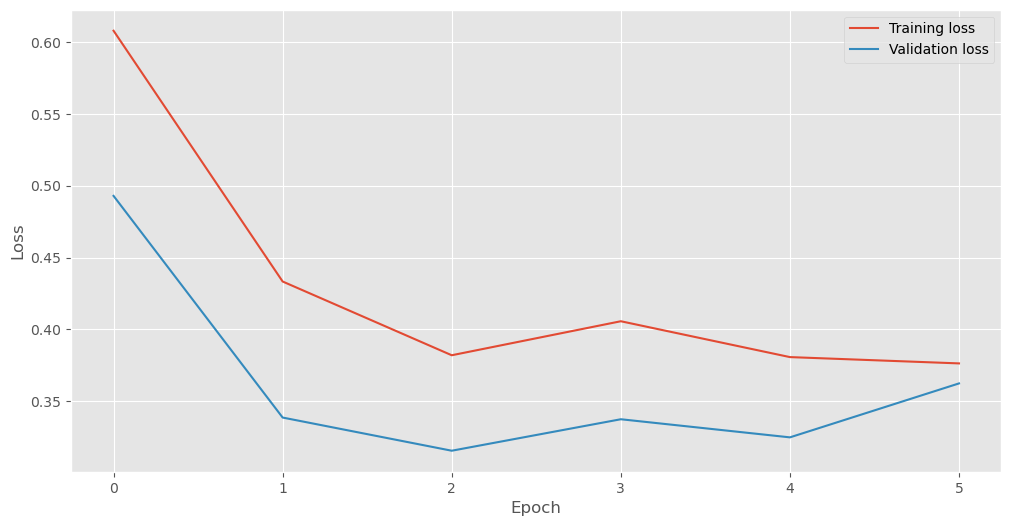

In [25]:
# Create a neural network model which loads the images and classifies them as tumor or non-tumor and the csv file with values like standard deviation, mean, etc.
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision(), Recall(), BinaryAccuracy()])

# Train the model
history = model.fit(train, validation_data=val, epochs=10, callbacks=[EarlyStopping(patience=3)])

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Model 2: Old Model

Epoch 1/10


c:\Users\fr3m3\anaconda3\envs\NeuNe_tensor\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 572ms/step - accuracy: 0.6671 - loss: 0.6300 - val_accuracy: 0.7943 - val_loss: 0.4324
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 569ms/step - accuracy: 0.7601 - loss: 0.4963 - val_accuracy: 0.8503 - val_loss: 0.3776
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 568ms/step - accuracy: 0.8145 - loss: 0.4057 - val_accuracy: 0.8724 - val_loss: 0.3353
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 570ms/step - accuracy: 0.8292 - loss: 0.3827 - val_accuracy: 0.8464 - val_loss: 0.3651
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 576ms/step - accuracy: 0.8162 - loss: 0.4034 - val_accuracy: 0.8477 - val_loss: 0.3766


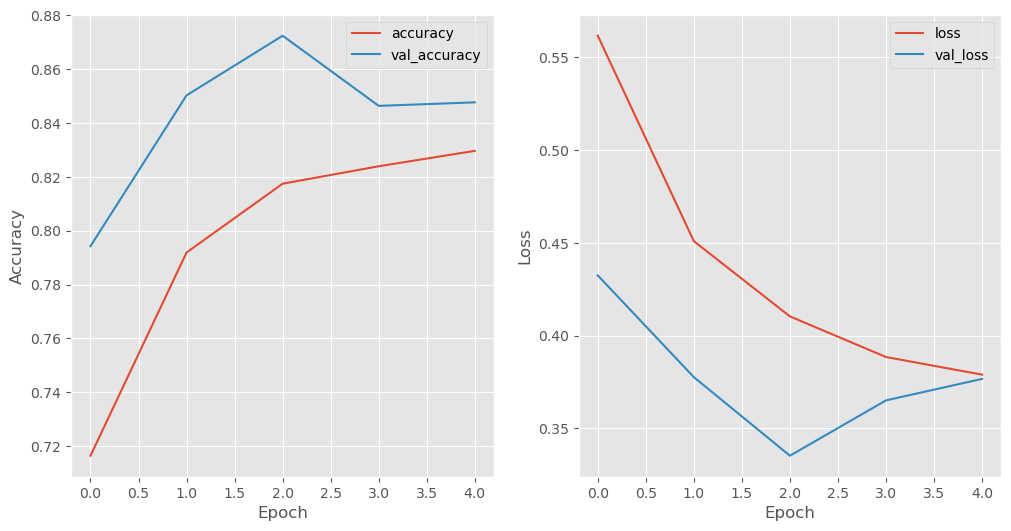

In [10]:
# Create the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(train, validation_data=val, epochs=10, callbacks=[early_stopping])

# Plot the accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
AUC: 0.9692307692307693
F1: 0.8333333333333334


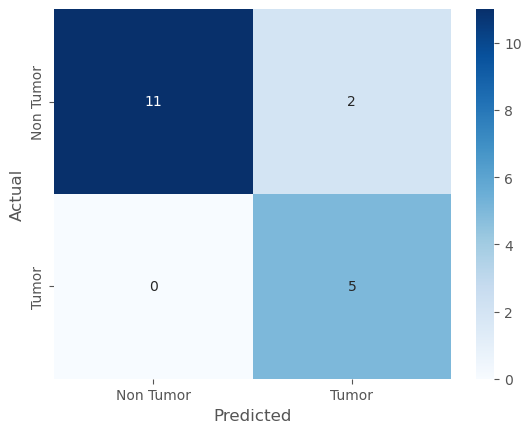

In [27]:
# Plot the AUC and F1 score
from sklearn.metrics import roc_auc_score, f1_score

# Get the predictions
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

# Calculate the AUC
auc = roc_auc_score(y, yhat)
print('AUC:', auc)

# Calculate the F1 score
f1 = f1_score(y, yhat > 0.5)
print('F1:', f1)

# Display the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y, yhat > 0.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
# rename the labels to tumor and non_tumor
plt.xticks([0.5, 1.5], ['Non Tumor', 'Tumor'])
plt.yticks([0.5, 1.5], ['Non Tumor', 'Tumor'])
plt.show()



# Evaluate Performance

In [28]:
# Messures used for classification problems, precision, recall and accuracy. 
# Establish instance of precision, recall and accuracy
pre =  Precision()
re = Recall()
acc = BinaryAccuracy()

In [29]:
len(test)

12

In [30]:
# Iterate over the test dataset
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

    # Reshape yhat if necessary to match the dimensions of y
    if yhat.shape[-1] == 1:
        yhat = tf.squeeze(yhat, axis=-1)  # Squeeze the last dimension

    # Update metric states
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)  # Here, we correctly use BinaryAccuracy

# Print the results after processing all batches
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Precision: 0.7920792102813721, Recall: 0.9523809552192688, Accuracy: 0.8657407760620117


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


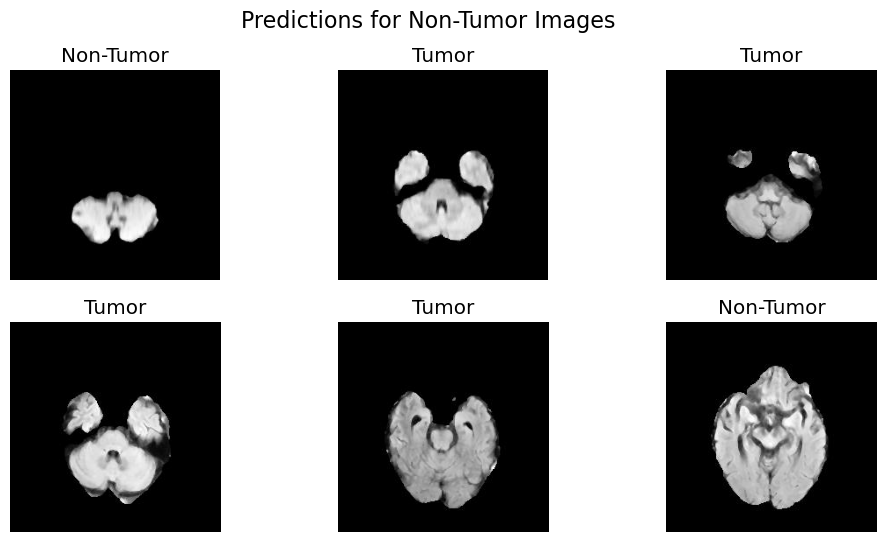

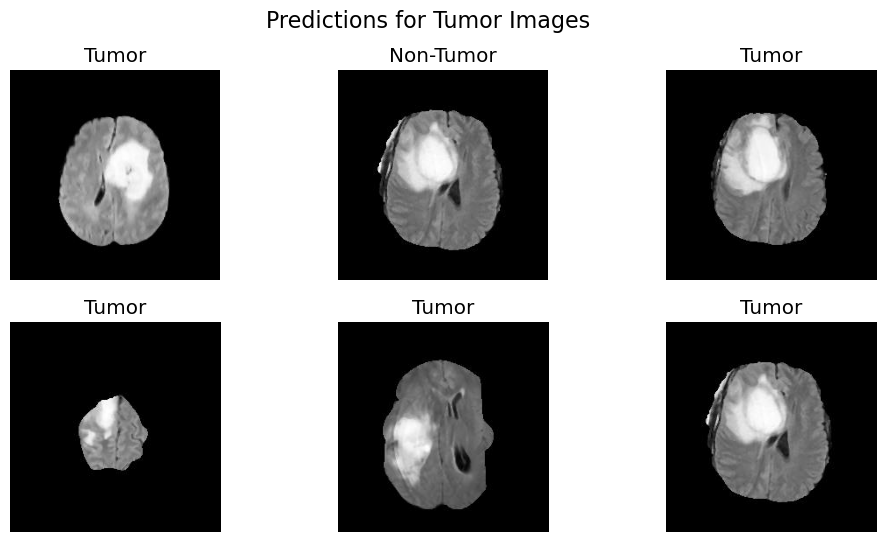

In [33]:
# Predictions on test dataset
predictions = model.predict(test)  # Use the 'test' dataset directly

tumor_folder = 'data/labeled/tumor'
non_tumor_folder = 'data/labeled/non_tumor'

# Display predictions for images from non_tumor_folder
plt.figure(figsize=(12, 6))
for i in range(6):
    # Load images directly from the folder
    img_path = os.path.join(non_tumor_folder, os.listdir(non_tumor_folder)[i])
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Tumor' if predictions[i+6] > 0.5 else 'Non-Tumor')
    plt.axis('off')
    plt.suptitle('Predictions for Non-Tumor Images', fontsize=16)
plt.show()

# Display predictions for images from tumor_folder
plt.figure(figsize=(12, 6))
for i in range(6):
    # Load images directly from the folder
    img_path = os.path.join(tumor_folder, os.listdir(tumor_folder)[i])
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Tumor' if predictions[i] > 0.5 else 'Non-Tumor')
    plt.axis('off')
    plt.suptitle('Predictions for Tumor Images', fontsize=16)
plt.show()

# Save the Model

In [20]:
# Create the model folder
os.makedirs('model', exist_ok=True)

# Save the model
model.save(os.path.join('model', 'brain_tumor_classifier.keras'))

# save the model in the h5 format
model.save('model/brain_tumor_classifier.h5')